In [45]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Requires: pip install pykan

import os
import seaborn as sns
import datetime as datetime

In [46]:
import kan


In [47]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_kan_feature(model, feature_name, feature_cols, X_train, scaler_X):
    """
    Plots the specific learned function (Physical Law) for a given feature.
    
    Args:
        model: The trained KAN model
        feature_name (str): The exact name of the column to plot (e.g. 'Wind Cooling')
        feature_cols (list): The list of all feature names used in training
        X_train (numpy array): The RAW (unscaled) training data (for calculating means/ranges)
        scaler_X (StandardScaler): The fitted scaler used to transform the data
    """
    
    # 1. Find the index
    try:
        feature_index = feature_cols.index(feature_name)
    except ValueError:
        print(f"❌ ERROR: '{feature_name}' not found in feature list.")
        return

    # 2. Setup Dimensions
    input_dim = X_train.shape[1]
    
    # 3. Create Synthetic Data (Base = Mean of everything)
    # We use 100 points for a smooth curve
    dummy_input_raw = np.zeros((100, input_dim))
    
    for i in range(input_dim):
        # Fill every column with its AVERAGE value from the real world
        # This isolates the feature we care about
        dummy_input_raw[:, i] = np.mean(X_train[:, i])

    # 4. Vary the Target Feature
    min_val = np.min(X_train[:, feature_index])
    max_val = np.max(X_train[:, feature_index])
    seq_values = np.linspace(min_val, max_val, 100)
    
    dummy_input_raw[:, feature_index] = seq_values

    # 5. Scale & Predict
    # The model speaks "Scaled", so we translate our raw numbers
    dummy_input_scaled = scaler_X.transform(dummy_input_raw)
    dummy_tensor = torch.from_numpy(dummy_input_scaled).float()

    model.eval()
    with torch.no_grad():
        predictions = model(dummy_tensor)
    
    # Flatten for plotting
    preds_flat = predictions.numpy().flatten()

    # 6. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(seq_values, preds_flat, color='#007acc', linewidth=3, label='KAN Learned Law')
    
    # Formatting
    plt.title(f"Effect of {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} (Physical Units)", fontsize=12)
    plt.ylabel("Clearsky Index (Efficiency)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add Reference Line
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label="100% Efficiency")
    
    # Add "Slope Arrow" to show direction
    if preds_flat[-1] > preds_flat[0]:
        color = 'green'
        msg = "Positive Impact"
    else:
        color = 'orange'
        msg = "Negative Impact"
        
    dx = max_val - min_val
    dy = preds_flat[-1] - preds_flat[0]
    # Only draw arrow if there is a significant change
    if abs(dy) > 0.05:
        plt.arrow(min_val, preds_flat[0], dx, dy, color=color, alpha=0.5, width=0.005)
        plt.text(min_val, preds_flat[-1], msg, color=color, fontweight='bold')

    plt.legend()
    plt.show()

In [48]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [49]:
hourly_nighlty_threshold = 50

In [50]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]


In [51]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

In [52]:

display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))

,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


In [53]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

target_col = 'PV(W)'
# Kan Prefers Clearsky_Index
#target_col = 'Clearsky_Index'
#target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
#feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
#feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [54]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [55]:

# ==========================================
# 1. Prepare Data (Using your winning "Error" target)
# ==========================================

# Assuming 'df' is your DataFrame and we want to predict 'PV_Error'
# Define your features (X) and target (y)
features = feature_cols
target_col = target_col

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=features + [target_col])
X = model_df[features].values
y = model_df[target_col].values.reshape(-1, 1)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize (Neural Networks LOVES scaled data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create dataset dictionary for pykan
# pykan expects keys: 'train_input', 'train_label', 'test_input', 'test_label'
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_scaled).float()
dataset['train_label'] = torch.from_numpy(y_train).float()
dataset['test_input'] = torch.from_numpy(X_test_scaled).float()
dataset['test_label'] = torch.from_numpy(y_test).float()


In [56]:
input_dim = X_train.shape[1]

In [58]:
# ==========================================
# 2. Define & Train the KAN
# ==========================================

# Initialize KAN
# width: [input_dim, hidden_dim, output_dim]
# grid: granularity of the spline grid (higher = more detailed but prone to overfitting)
# k: order of the spline (k=3 is cubic)
input_dim = X_train.shape[1]
print(f"Input dimension for KAN: {input_dim}")

model = kan.KAN(width=[input_dim,8, 1],
                 grid=12, 
                 k=3, 
                 seed=42)

print("Starting KAN Training (using LBFGS optimizer)...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Train the KAN model using the dataset dictionary
print("\nTraining KAN model with LBFGS optimizer...")
results = model.fit(dataset, 
                    opt='LBFGS', 
                    steps=40, 
                    lamb=0.005, 
                    lamb_entropy=0.01)

print("\n✓ KAN Training Complete!")
print(f"Training iterations completed: 50")




Input dimension for KAN: 16
checkpoint directory created: ./model
saving model version 0.0
Starting KAN Training (using LBFGS optimizer)...
Input dimension: 16
Training samples: 3508
Test samples: 878

Training KAN model with LBFGS optimizer...


| train_loss: nan | test_loss: nan | reg: nan | :  25%|███▎         | 10/40 [00:08<00:24,  1.24it/s]

lstsq failed


UnboundLocalError: cannot access local variable 'coef' where it is not associated with a value

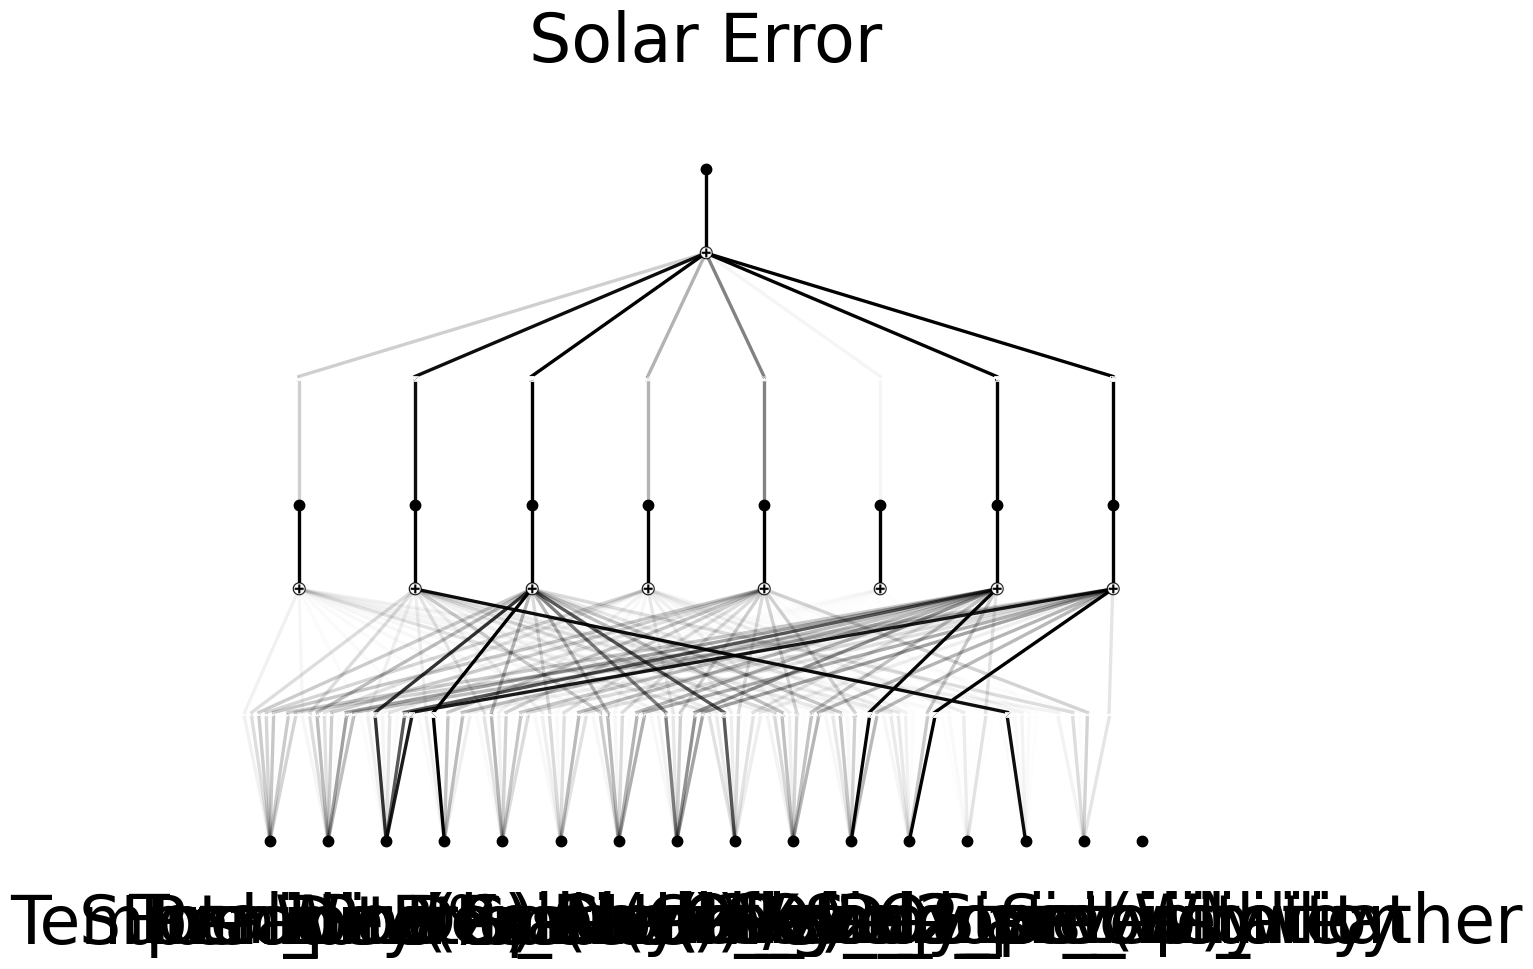

In [ ]:
# Visualize the learned functions
# scale=1.0 scales the diagram size
model.plot(beta=10, scale=1.2, in_vars=features, out_vars=['Solar Error'])
plt.show()

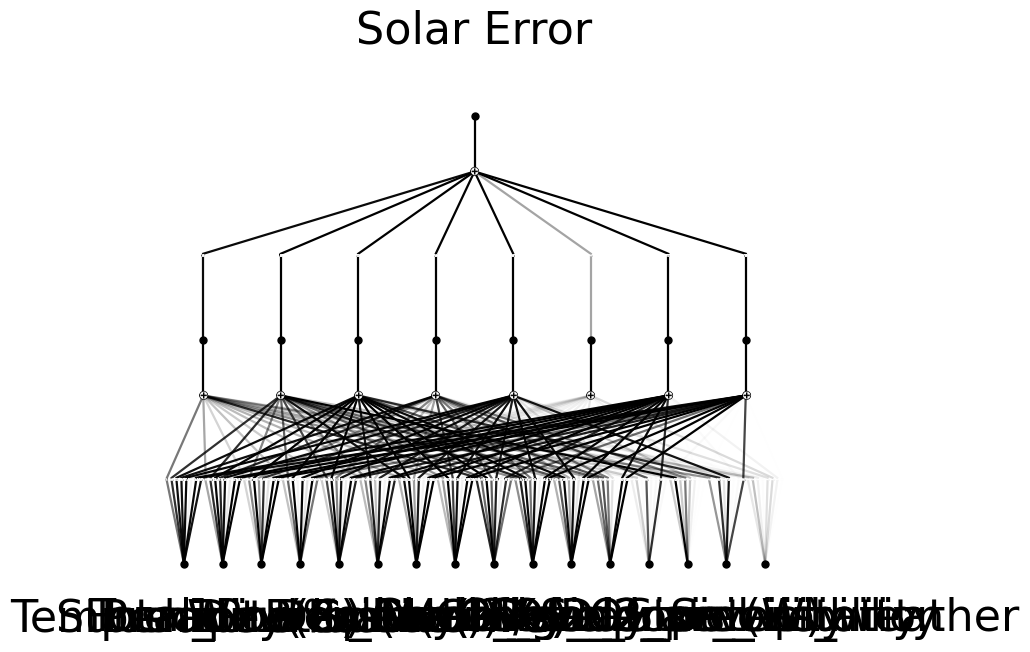

In [ ]:

# 2. Visualize the Physics (The Best Part of KAN!)
# This plots the actual activation functions the model learned.
# You can see if "Temperature" looks linear or curved.
model(dataset['train_input']) 
model.plot(beta=100,scale=0.8, in_vars=features, out_vars=['Solar Error']) 
plt.show()


<Figure size 2000x1500 with 0 Axes>

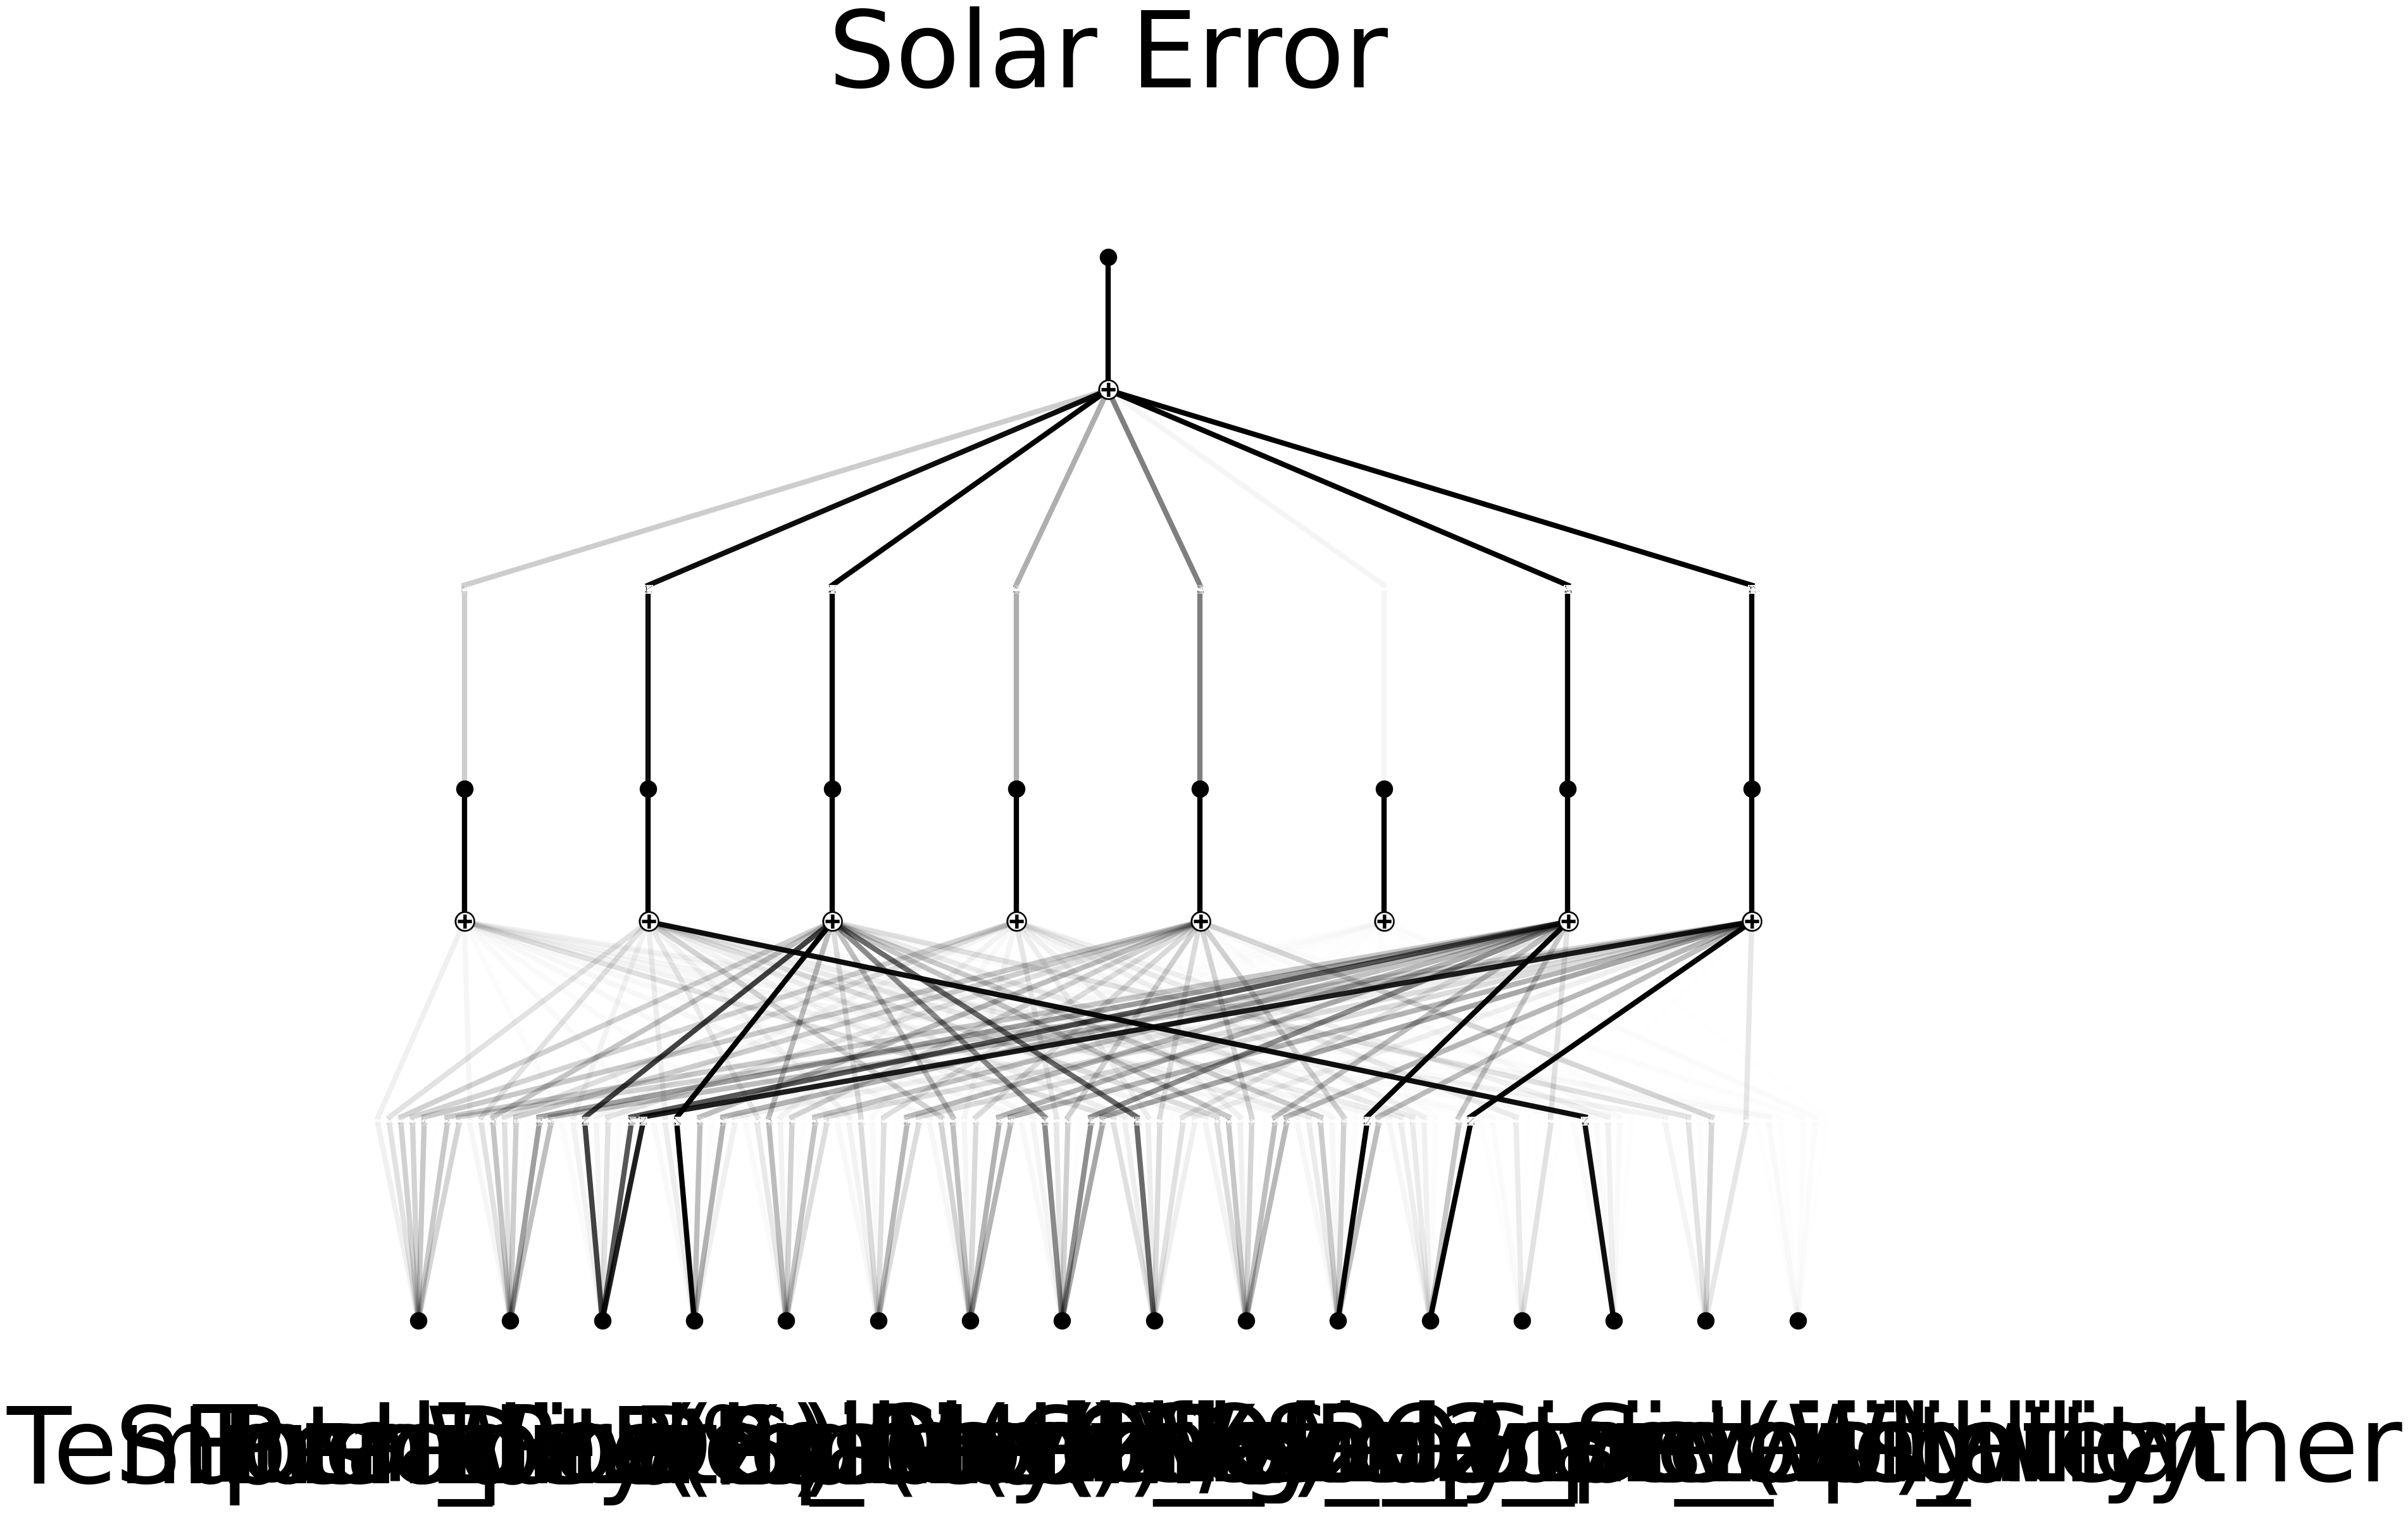

In [ ]:
import matplotlib.pyplot as plt

# 1. Set a huge canvas size explicitly
plt.figure(figsize=(20, 15))

# 2. Increase 'scale' significantly (Try 3.0 or 4.0)
# scale: Multiplies the distance between nodes. 
# tick: Adds tick marks to the axes of the small graphs (True/False)
model.plot(beta=10, scale=3.0, tick=True, in_vars=feature_cols, out_vars=['Solar Error'])

plt.show()

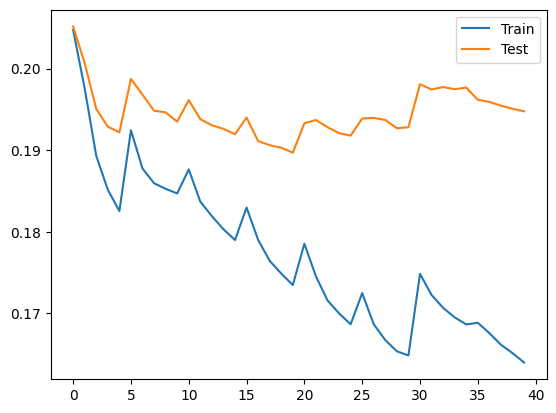

In [ ]:
# 3. Check for Convergence
plt.plot(results['train_loss'], label='Train')
plt.plot(results['test_loss'], label='Test')
plt.legend()
plt.show()

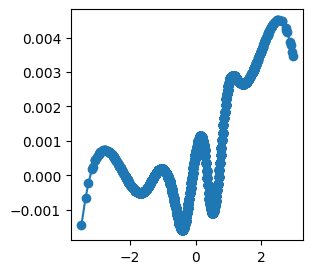

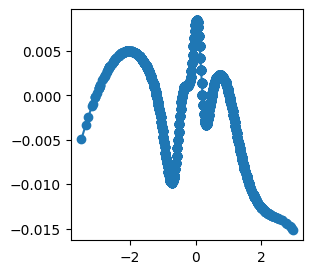

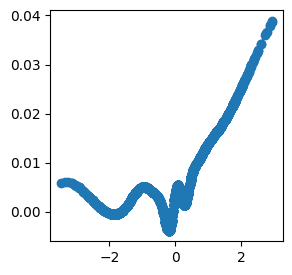

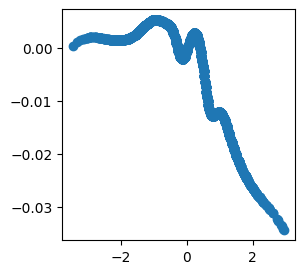

In [ ]:
l = 0
i = 0
j = 3
x, y = model.get_fun(l,i,0)
x, y = model.get_fun(l,i,1)
x, y = model.get_fun(l,i,2)
x, y = model.get_fun(l,i,j)

❌ ERROR: 'Wind Cooling' not found in feature list.


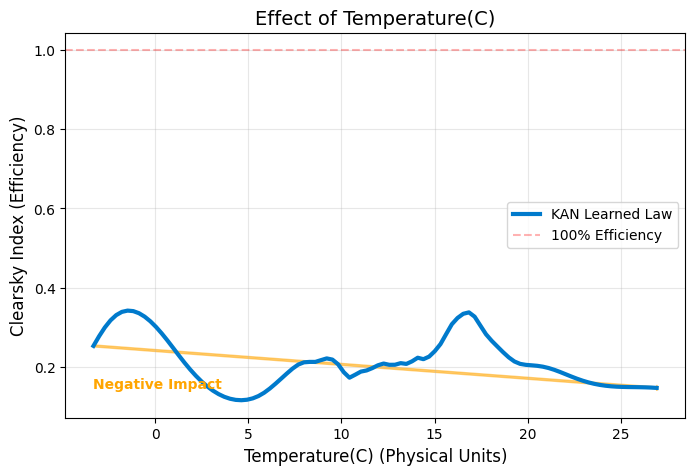

❌ ERROR: 'Clear sky GHI' not found in feature list.


In [ ]:
# Check Wind Cooling (Should go UP)
plot_kan_feature(model, "Wind Cooling", feature_cols, X_train, scaler_X)

# Check Temperature (Should go DOWN)
plot_kan_feature(model, "Temperature(C)", feature_cols, X_train, scaler_X)

# Check Sun Position (Should curve)
plot_kan_feature(model, "Clear sky GHI", feature_cols, X_train, scaler_X)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# Get Predictions from the Model
# =========================================================

# Get predictions on test set
model.eval()
with torch.no_grad():
	y_pred_tensor = model(dataset['test_input'])
y_pred = y_pred_tensor.numpy()

# =========================================================
# Get the Clear Sky values for your test set
# =========================================================
# Find the index of 'Clear sky GHI' in feature_cols
clearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')

# Extract the Clear Sky GHI values from X_test_scaled
# We need to inverse-transform to get the actual values
clearsky_scaled = X_test_scaled[:, clearsky_index].reshape(-1, 1)

# Create a dummy array with zeros and replace the column with our clearsky values
dummy_for_inverse = np.zeros((X_test_scaled.shape[0], X_train.shape[1]))
dummy_for_inverse[:, clearsky_index] = clearsky_scaled.flatten()

# Inverse transform to get actual values (only the clearsky column matters)
clearsky_ref = scaler_X.inverse_transform(dummy_for_inverse)[:, clearsky_index].reshape(-1, 1)

# =========================================================
# Reconstruct Total Values
# =========================================================
# Your model predicts Clearsky_Index (a normalized error)
# To get actual watts, you multiply by Clear Sky GHI

y_test_total = y_test * clearsky_ref
y_pred_total = y_pred * clearsky_ref

# Physics Clamp (Force negatives to 0)
y_pred_total = np.clip(y_pred_total, 0, None)
y_test_total = np.clip(y_test_total, 0, None)

# =========================================================
# Calculate Metrics
# =========================================================

# 1. Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_total, y_pred_total)

# 2. Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test_total, y_pred_total)
rmse = np.sqrt(mse)

# 3. Calculate R^2 Score
r2 = r2_score(y_test_total, y_pred_total)

# 4. Normalized Metrics
capacity = y_test_total.max()
n_mae = (mae / capacity) * 100
n_rmse = (rmse / capacity) * 100

print(f"MAE:  {mae:.2f} W")
print(f"RMSE: {rmse:.2f} W")
print(f"R²:   {r2:.4f}")
print(f"N-MAE: {n_mae:.2f}%")
print(f"N-RMSE: {n_rmse:.2f}%")

MAE:  450.27 W
RMSE: 614.47 W
R²:   0.8044
N-MAE: 8.00%
N-RMSE: 10.92%


__Save Model__

In [ ]:
model.saveckpt(f"{MODEL_DIR}/kan_model_target.ckpt")